# Galactic Log SED Fitting

## Ben Hanson

### Import Modules

In [1]:
import h5py
import import_ipynb
import os
os.environ['SPS_HOME'] = '/home/benjamin.hanson/UF REU/SED-Fitting/UF-REU-PROJECT'
import fsps
%matplotlib inline
import math
import matplotlib.pyplot as plt
import csv
import numpy as np
import scipy.odr.odrpack as odrpack
import math
import scipy as scipy
from scipy import optimize
from scipy import interp
from scipy import integrate
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm
import sys
import csv
from importlib import reload
from rbvfit import model as m
from datetime import date
reload(m)

import emcee
import corner
import scipy.optimize as op

width = 30

import time
from multiprocessing import cpu_count
from multiprocessing import Pool
import random
from IPython.display import clear_output

### Define Functions

In [115]:
def creating_array(metallicity_array, age_array):
    
    mass_array = []
    
    print("Deleting previous iterations of spectrums...")
    # Deleting previous iteration of spectrum
    if 'sp' in locals():
        del sp
    
    rows = len(metallicity_array)
    columns = len(age_array)
    with open('stellar_bank_{}x{}.csv'.format(str(int(rows)), str(int(columns))), 'w') as f:
        write = csv.writer(f)
        print("Creating new array...")
        # Creating Array
        
        sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol = 0, dust_type=2, dust2=0.0)
       
        for i in range(len(metallicity_array)):
            
            metallicity = metallicity_array[i]
            sp.params['logzsol'] = metallicity
                        
            for j in range(len(age_array)):
                
                age = age_array[j]
                wave, spec = sp.get_spectrum(tage = age)
                mass_array.append(str(sp.stellar_mass))
                spec = list(spec)
                spec = list(map(str, spec))
                write.writerow(spec)   
    
    print("Spectrum array complete. Writing Mass Array.")
    with open('stellar_bank_{}x{}_mass.csv'.format(str(int(rows)), str(int(columns))), 'w') as f:
        write = csv.writer(f)
        
        for i in range(len(mass_array)):
            
            value = mass_array[i]
            write.writerow([value])
            
    print("Mass Array Complete")    
        
def reading_csv(file_name, rows, columns):
    
    print("Reading array...")
    new_array = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            new_array.append(row)
    
    print("Unflattening array...")
    # Unflattening Array
    uf_array = []
    uf_sub_array = []

    r = rows
    c = columns
    iterator = 0

    for i in range(r):
        for j in range(c):
            new_array[iterator] = list(map(float, new_array[iterator]))
            uf_sub_array.append(new_array[iterator])
            iterator += 1
        uf_array.append(uf_sub_array)
        uf_sub_array = []
    
    return uf_array

def reading_csv_obs(file_name, rows, columns, fields, layers):
    
    print("Reading array...")
    new_array = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            new_array.append(row)
    
    print("Unflattening array...")
    # Unflattening Array
    uf_array = []
    uf_sub_array = []
    uf_sub_sub_array = []
    uf_sub_sub_sub_array = []

    r = rows
    c = columns
    f = fields
    l = layers
    iterator = 0

    for i in range(r):
        for j in range(c):
            for k in range(f):
                for m in range(l):
                    new_array[iterator] = list(map(float, new_array[iterator]))
                    uf_sub_sub_sub_array.append(new_array[iterator])
                    iterator += 1
                uf_sub_sub_array.append(uf_sub_sub_sub_array)
                uf_sub_sub_sub_array = []
            uf_sub_array.append(uf_sub_sub_array)
            uf_sub_sub_array = []
        uf_array.append(uf_sub_array)
        uf_sub_array = []        
    
    return uf_array

def make_spectrum(age, metallicity):
    sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol= metallicity, dust_type=2, dust2=0.0)
    wave, spec = sp.get_spectrum(tage = age)
    del sp
    
    return wave, spec
    
def chi_sq_func(obs_Spec, exp_Spec):
    chiSq = 0
    for i in range(len(obs_Spec)):
        chiSq += ((obs_Spec[i] - exp_Spec[i])**2)/exp_Spec[i]
        
    return chiSq

def plt_spectra(wave, spec, theta):
    plt.loglog(wave, spec, label = "Params: logZ = {}, Age (Gyr) = {}".format(theta[0], theta[1]))

def model_guess(beta,input_wave):
    
    spec = interpolating_spec(beta)[0]
    
    if (len(spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, spec)
        spec = trunc_spec    

    return spec

def model_guess_obs(beta,input_wave):
    
    spec = obs_interpolating_spec(beta)[0]
    
    if (len(spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, spec)
        spec = trunc_spec    

    return spec
    
def make_corner_plots(sampler):
          
    samples=sampler.chain[:, 100:, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    figure=corner.corner(samples, labels=text_label, truths=st)
    theta_prime=st

    value1 =np.percentile(samples,32,axis=0)
    value2 = np.percentile(samples,68,axis=0)    
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1[i], color="aqua")
        ax.axvline(value2[i], color="aqua")

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value1[xi],color="aqua")
            ax.axvline(value2[xi],color="aqua")
            #ax.axhline(value1[yi], color="g")
            #ax.axhline(value2[yi], color="r")
            #ax.plot(value1[xi], value1[yi], "sg")
            #ax.plot(value2[xi], value2[yi], "sr")

def build_weight_array(weight_array, row_array, column_array, weight_added_array):
    for i in range(len(row_array)):
        weight_array[row_array[i]][column_array[i]] += weight_added_array[i]
    return weight_array    

def generate_random_weight_array(lb, ub, metallicity_array, age_array):
    
    weight_array= []
    
    s2 = np.random.normal(1.0, 0.01, 10000)
    count2, bins2, ignored2 = plt.hist(s2, 3, stacked = True, density = True)

    count2 *= 1 / count2[1]
    
    for i in range(len(metallicity_array)):
        bounds = np.array([lb, ub])
        mean = np.mean(bounds)
        std = mean * 0.1
        s = np.random.normal(mean, std, 10000)
        count, bins, ignored = plt.hist(s, 10, stacked = True, density = True)
        
        correction = 1 / sum(count)
        count *= correction 
        count *= count2[i] * ub
    
        count[count > ub] = ub
        count[count < lb] = lb
        weight_array.append(list(count))
    
    return weight_array
                      
def galactic_spec(weight_array):
    
    row_array, column_array = convert_weight_array(weight_array, metallicity_space, age_space)
    met_array, age_array = convert_arrays(row_array, column_array, metallicity_space, age_space)
    weight_array = weight_array.flatten()

    total_spec = np.zeros(5994)

    for i in range(len(met_array)):
        met = np.array([met_array[i]])
        age = np.array([age_array[i]])

        theta = np.concatenate((met, age))
        spec = interpolating_spec(theta)[0]
        total_spec += (spec * weight_array[i])
    
    return total_spec

def galactic_model_guess(weight_array, input_wave):
    
    total_spec = galactic_spec(weight_array)
    
    if (len(total_spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, total_spec)
        total_spec = trunc_spec        
    
    return total_spec

def print_and_plot_results(sampler, wave, spec, title, galaxy, model):
    
    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    theta_prime=st[:]
    
    print("Derived values are (weight array): \n {}".format(theta_prime))   
    best_fit = model(theta_prime, wave)

    fig= plt.figure(figsize=(12,8))
    
    plt.loglog(wave, spec, ls = 'dotted', label= galaxy) 
    plt.title(title, fontsize = 20)
    plt.ylabel('Intensity (Solar luminosity/Hz)', fontsize = 18) # Labeling the x-axis
    plt.xlabel('Wavelength (Angstroms)', fontsize = 18) # Labeling the y-axis
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})
    
    return best_fit, theta_prime

def convert_arrays(row_array, column_array, metallicity_space, age_space):
    
    met_array = []
    age_array = []
    
    for i in range(len(row_array)):
        met_array.append(metallicity_space[row_array[i]])
        age_array.append(round(age_space[column_array[i]], 4))
        
    return met_array, age_array

def convert_weight_array(weight_array, metallicity_space, age_space):
    
    row_array = []
    column_array = []
    weight_array = np.reshape(weight_array, (len(metallicity_space), len(age_space)))
    
    for i in range(len(weight_array)):
        for j in range(len(weight_array[0])):
            if (weight_array[i][j] != 0):
                row_array.append(i)
                column_array.append(j)
                
    return row_array, column_array

######## Computing Likelihoods######
def lnprior(theta, lb, ub):
    for index in range(0, len(lb)):
        if (lb[index] > theta[index]) or (ub[index] < theta[index]):
            return -np.inf
    return 0.0

def lnlike(theta, model, x, y, yerr):
    model_y = model(theta, x)
    model_y = np.log10(model_y)
    y = np.log10(y)
    yerr = y * 0.1
    inv_sigma2 = 1.0/(yerr**2)
    all_c2_values = (y - model_y) ** 2 * inv_sigma2  - np.log10(inv_sigma2)
    return -0.5 * (np.sum( all_c2_values  )) 

def lnprob(theta, lb, ub, model, x, y, yerr):
    lp = lnprior(theta, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model, x, y, yerr)

def optimize_guess(model, theta, lb, ub, x, y, yerr):
    nll = lambda *args: -lnprob(*args)
    result = op.minimize(nll, [theta], args=(lb, ub, model, x, y, yerr))
    p = result["x"]
    return p

def galsedatlas_read_spectral_data(filename):
    rest_wave = []
    flux = []
    obs_wave = []
    source = []
    iterator = 0
    with open(filename, 'r') as f:
        for line in f:
            if (line[0] != '#'):
                line = line.split()
                for item in line:
                    if((item != " ") or (item != "\n")):
                        if (iterator % 4 == 0):
                            rest_wave.append(float(item))
                        elif (iterator % 4 == 1):
                            flux.append(float(item))
                        elif (iterator % 4 == 2):
                            obs_wave.append(float(item))
                        else:
                            source.append(float(item))

                        iterator += 1

    rest_wave = np.array(rest_wave)
    flux = np.array(flux)
    flux *= (rest_wave ** 2)
    obs_wave = np.array(obs_wave)
    source = np.array(source)
    return np.array(rest_wave), np.array(flux), np.array(obs_wave), np.array(source)

def add_to_bank(filename, description, array):
    array = list(array)
    array.insert(0, description)
    
    with open(filename, 'a') as f:
        write = csv.writer(f)
        write.writerow(array)
        
def read_through_bank(filename, description):
    try_again = True
    array = []
    while try_again == True:
        with open(filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                if row[0] == description:
                    array = row
                    try_again = False
        if (try_again == True):
            print("Description not found. Input new description")
            description = str(input())
        if (description == "Exit"):
            print("Exiting")
            return array
        
    array.pop(0)
    array = [float(i) for i in array]
    return array

def mass_to_light_calc(input_weight_array, input_spec, input_wave):
    
    mass_light_ratio = 0
    total_luminosity = 0
    
    c = 3E18
    frequency = c / input_wave
    frequency = np.flip(frequency)
    input_spec = np.flip(input_spec)

    total_luminosity = np.trapz(input_spec,frequency)              
    
    row_array, column_array = convert_weight_array(input_weight_array, metallicity_space, age_space)
    met_array, age_array = convert_arrays(row_array, column_array, metallicity_space, age_space)
    input_weight_array = input_weight_array.flatten()

    total_mass = 0

    for i in range(len(met_array)):
        met = np.array([met_array[i]])
        age = np.array([age_array[i]])

        theta = np.concatenate((met, age))
        mass = interpolating_mass(theta)[0][0]
        total_mass += (input_weight_array[i] * mass)
        
    mass_light_ratio = total_mass / total_luminosity
    
    return mass_light_ratio

def total_luminosity_calc(input_spec, input_wave):
    
    total_luminosity = 0
    
    c = 3E18
    frequency = c / input_wave
    frequency = np.flip(frequency)
    input_spec = np.flip(input_spec)

    total_luminosity = np.trapz(input_spec,frequency)              
    
    return total_luminosity

def get_uncertainty(sampler):
    
    sampler_ = np.array( sampler.chain )
    sub_array = []
    position_array = []
    chain_length = len(sampler_[0])
    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []

    position_array = np.array(position_array)

    distributions = []
    sub_array = []
    
    for i in range(len(position_array[0])):
        for j in range(len(position_array)):
            sub_array.append(position_array[j][i])

        distributions.append(sub_array)
        sub_array = []

    distributions = np.array(distributions)
    
    unc = []
    
    for i in range(len(distributions)):
        unc.append(distributions[i].std())
        
    return unc     

def interpolating_spec_model(theta, x):
    spec = setting_min(interpolating_spec(theta)[0])
    
    return spec

def clear_csv(filename):
    f = open(filename, "w+")
    f.close()
    
def mass_light_pdf(sampler, sample_size, input_spec, input_wave):
    sampler_ = np.array( sampler.chain )
    sub_array = []
    position_array = []
    chain_length = len(sampler_[0])
    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []

    position_array = np.array(position_array)

    distributions = []
    sub_array = []

    for i in range(len(position_array[0])):
        for j in range(len(position_array)):
            sub_array.append(position_array[j][i])

        distributions.append(sub_array)
        sub_array = []

    distributions = np.array(distributions)
    cdf_array = []
    bin_array = []

    for i in range(len(distributions)):

        # Creating CDFs
        count, bins = np.histogram(distributions[i])
        prob = count / sum(count)
        plt.hist(bins[:-1], bins, alpha = 0.5, weights=prob, label = "Bin {} Probability Distribution".format(i))
        mu1, sigma1 = scipy.stats.norm.fit(distributions[i])
        cdf = scipy.stats.norm.cdf(bins, mu1, sigma1)
        cdf_array.append(cdf)
        bin_array.append(bins)
        plt.plot(bins, cdf, label = "CDF")
        plt.locator_params(axis="x", nbins=5)
        plt.legend()
        plt.show()
    
    fig= plt.figure(figsize=(12,8))
    
    samples = sample_size
    weight_array = []
    sub_array = []
    for i in range(samples):

        for j in range(len(distributions)):

            #Pick Random Value Along CDF
            rand = random.uniform(0, 1)
            value = np.interp(rand, cdf_array[j], bin_array[j])
            sub_array.append(value)
        weight_array.append(sub_array)
        sub_array = []
        
    weight_array = np.array(weight_array)
    
    mass_light_array = []
    derived_spec_array = []
    for i in range(samples):
        
        derived_spec = galactic_model_guess(weight_array[i], input_wave)
        derived_spec_array.append(derived_spec)
        
        mass_light = mass_to_light_calc(weight_array[i], derived_spec, input_wave)
        mass_light_array.append(mass_light)
    
    for i in range(len(derived_spec_array)):
        plt.loglog(input_wave, derived_spec_array[i])
    plt.show()
    
    fig = plt.figure(figsize = (12, 8))
    count, bins = np.histogram(mass_light_array)
    prob = count / sum(count)
    plt.hist(bins[:-1], bins, alpha = 0.5, weights=prob, label = "Derived Mass/Light PDF".format(i))
    mu2, sigma2 = scipy.stats.norm.fit(mass_light_array)
    
    return mu2, sigma2

def gelman_rubin(sampler):
    
    chain = sampler.chain[:, :, :]
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    theta_b = np.mean(chain, axis=1)
    theta_bb = np.mean(theta_b, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((theta_bb - theta_b)**2, axis=0)
    var_theta = (n - 1) / n * W + 1 / n * B
    R = np.sqrt(var_theta / W)
    
    return R

def initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm, enorm, input_wave, model, path):
    
    likelihood = []
    fits = []
    weight_arrays = []
    total_steps = 0
    curr_likelihood = 0
    convergence_status = False
    convergences = []
    if (convergence_check == False):
        
        while (total_steps < break_steps):
            pos, prob, state = sampler.run_mcmc(pos, no_of_steps, progress = True)
            clear_output(wait=True)
            samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
            st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
            curr_likelihood = lnlike(st, model, input_wave, snorm, enorm)
            likelihood.append(curr_likelihood)
            total_steps += no_of_steps
            print("Steps Taken: ", total_steps, "Likelihood: ", curr_likelihood)
    else:
        while(convergence_status == False):
            pos, prob, state = sampler.run_mcmc(pos, no_of_steps, progress = True)
            
            # Saving Final Position
            with open(path + '/current_pos.csv','w') as f:
                write = csv.writer(f)

                for i in range(len(pos)):
                    write.writerow(pos[i])
                    
            clear_output(wait=True)
            samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
            st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
            curr_likelihood = lnlike(st, model, input_wave, snorm, enorm)
            likelihood.append(curr_likelihood)

            convergence_status, R = check_convergence(sampler, convergence_accuracy)
            
            with open(path + '/convergence_file.csv', 'a') as f:
                write = csv.writer(f)
                write.writerow(R)
            
            total_steps += no_of_steps
            print("Steps Taken: ", total_steps, "Likelihood: ", curr_likelihood)
            if (total_steps >= break_steps):
                convergence_status = True
                print("Convergence not found before break.")

        print("Total steps to converge: ", total_steps)

    return sampler, likelihood, convergences

def check_convergence(sampler, convergence_accuracy):
    
    # Checking Convergence of Walkers
    
    R = gelman_rubin(sampler)

    convergence_status = True
    for i in range(len(R)):
        if (convergence_accuracy < R[i]):
            print("Parameter {} has not converged. GR was {:.3f}.".format(i, R[i]))
            convergence_status = False
            break
            
    return convergence_status, R

def plot_convergences(file_name, convergence_accuray, no_of_steps):

    convergences = []
    iterator = 0
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            convergences.append(np.array(list(map(float, row))))
            iterator += 1

    new_convergences = []
    sub_array = []
    for i in range(len(convergences[0])):
        for j in range(len(convergences)):

            sub_array.append(convergences[j][i])

        new_convergences.append(sub_array)
        sub_array = []

    fig = plt.figure(figsize = (12, 8))

    break_steps = no_of_steps * iterator
    x = np.linspace(no_of_steps, break_steps, num = len(new_convergences[0]))

    for i in range(len(new_convergences)):
        plt.plot(x, new_convergences[i])
    plt.hlines(convergence_accuracy, no_of_steps, plt.xlim()[1], ls = "--", label = "GR Convergence Value")
    plt.legend()
    plt.title("Gelman-Rubin Convergence of Walkers", fontsize = 20)
    plt.ylabel('Gelman-Rubin Value', fontsize = 18) # Labeling the x-axis
    plt.xlabel('Steps', fontsize = 18) # Labeling the y-axis
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})
    plt.ylim([0, plt.ylim()[1]])
    plt.savefig("{}_steps_convergence_{}.jpg".format(str(break_steps), str(date.today())))
    plt.show()
    
def save_variables(path, input_weight_array, snorm, enorm, spec_opt_guess):
    with open(path + "/save_variables.csv", 'w') as f:
        write = csv.writer(f)
        write.writerow(input_weight_array)
        write.writerow(snorm)
        write.writerow(enorm)
        write.writerow(spec_opt_guess)

def read_variables(filename):
    
    iterator = 0
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if (iterator == 0):
                input_weight_array = row
                iterator += 1
            elif (iterator == 1):
                snorm = row
                iterator += 1
            elif (iterator == 2):
                enorm = row
                iterator += 1
            elif (iterator == 3):
                spec_opt_guess = row
    
    return input_weight_array, snorm, enorm, spec_opt_guess                

### Initializing Wavelength Array

In [6]:
wave = []
with open('wave.txt', 'r') as f:
    wave = f.readlines()
wave = np.array(list(map(float, wave)))

### Creating Interpolate Function

In [7]:
file_name = "Stellar Banks/stellar_bank_3x10.csv"
rows = 3
columns = 10
spec_data = reading_csv(file_name, rows, columns)

file_name = "Stellar Banks/stellar_bank_3x10_mass.csv"
rows = 3
columns = 10
mass_data = reading_csv(file_name, rows, columns)

Reading array...
Unflattening array...
Reading array...
Unflattening array...


In [8]:
metallicity_array = np.array([-3, 0, 1])
age_array = np.logspace(-3, 1.146, 10)
interpolating_spec = RegularGridInterpolator((metallicity_array, age_array), spec_data, bounds_error = False, fill_value = None)
interpolating_mass = RegularGridInterpolator((metallicity_array, age_array), mass_data, bounds_error = False, fill_value = None)

### Galactic SED Fitting

Setting the "space", aka the combination of age-metallicities that mcmc will fit.

In [99]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.logspace(-3, 1.146, 10)
ndim = len(metallicity_space) * len(age_space)
nwalkers = 5 * ndim

Creating a random gaussian weight array, then creating SED from that array to use as target signal.

[1.00048864e-03 9.62008307e-03 4.79464940e-02 1.43069875e-01
 2.24879062e-01 2.11872710e-01 9.93562179e-02 2.82445639e-02
 3.38626924e-03 2.30881994e-04 1.15000000e-02 7.80000000e-02
 3.73500000e-01 1.00800000e+00 1.46750000e+00 1.25550000e+00
 6.00500000e-01 1.79000000e-01 2.50000000e-02 1.50000000e-03
 1.69191302e-04 1.99645737e-03 1.39413633e-02 4.87270950e-02
 9.37319814e-02 9.86723675e-02 5.89800880e-02 1.78666015e-02
 3.99291473e-03 3.04544344e-04]


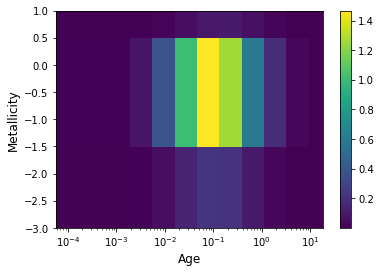

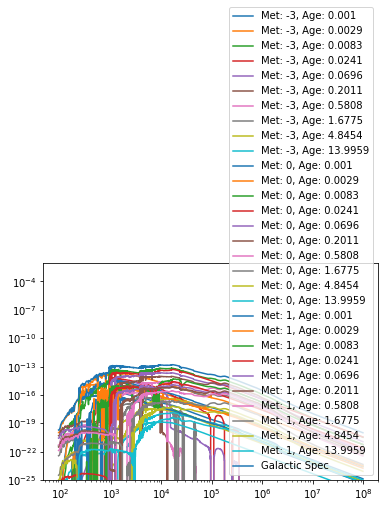

In [100]:
lb = 0
ub = int(5)

test_weight_array3 = np.array(generate_random_weight_array(lb, ub, metallicity_space, age_space))
plt.clf()
test_weight_array3 = test_weight_array3.flatten()
print(test_weight_array3)

row_array, column_array = convert_weight_array(test_weight_array3, metallicity_space, age_space)
met_array3, age_array3 = convert_arrays(row_array, column_array, metallicity_space, age_space)

# Printing Contour Map
plt.pcolormesh(age_space, metallicity_space, test_weight_array3.reshape((len(metallicity_space), len(age_space))), shading='auto')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Metallicity', fontsize = 12)
plt.xscale('log')
plt.ylim([-3, 1])
plt.colorbar()
plt.show()
plt.clf()

test_weight_array3 = test_weight_array3.flatten()

total_spec3 = np.zeros(5994)

for i in range(len(met_array3)):
    met3 = np.array([met_array3[i]])
    age3 = np.array([age_array3[i]])
    
    theta3 = np.concatenate((met3, age3))
    spec3 = interpolating_spec(theta3)[0]
    spec3 *= test_weight_array3[i]
    plt.loglog(wave, spec3, label = "Met: {}, Age: {}".format(met3[0], age3[0]))
    total_spec3 += spec3

snorm3 = total_spec3 + np.random.normal(0., 1e-24, len(wave))
enorm3  = 1e-24 * np.ones((len(wave),))

plt.loglog(wave, snorm3, label = "Galactic Spec")
plt.legend()
plt.ylim([1e-25, 1e-2])
plt.show()

Using Optimization to get general fit for starting point.

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Input values were (metallicity,age):
[1.00048864e-03 9.62008307e-03 4.79464940e-02 1.43069875e-01
 2.24879062e-01 2.11872710e-01 9.93562179e-02 2.82445639e-02
 3.38626924e-03 2.30881994e-04 1.15000000e-02 7.80000000e-02
 3.73500000e-01 1.00800000e+00 1.46750000e+00 1.25550000e+00
 6.00500000e-01 1.79000000e-01 2.50000000e-02 1.50000000e-03
 1.69191302e-04 1.99645737e-03 1.39413633e-02 4.87270950e-02
 9.37319814e-02 9.86723675e-02 5.89800880e-02 1.78666015e-02
 3.99291473e-03 3.04544344e-04]
Optimizing Guess ***********


/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.16831725 0.2022158  0.01392596 0.04935253 0.02927441 0.02004305
 0.01917458 0.01772295 0.01428589 0.01234992 0.25045206 0.32823196
 0.62490653 0.13305182 0.07722936 0.0457534  0.02821209 0.02080211
 0.01393899 0.01174501 0.32142746 0.38669154 0.39684459 0.08553695
 0.04938084 0.04193701 0.03056128 0.01574306 0.01331452 0.01182668]


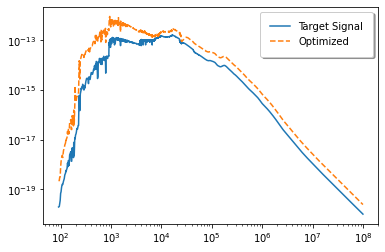

In [101]:
text_label = []

for i in range(30):
    text_label.append('mass'+ str(i))
    
lb   = np.zeros(30)
ub   = np.full(30, 1e10)

starting_weight_array = np.full(30, 0.01)

print("Current Starting Position")
print(starting_weight_array)
print("Input values were (metallicity,age):")
print(test_weight_array3)

print('Optimizing Guess ***********')

popt3 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, wave, snorm3, enorm3)
print(popt3)

spec_opt_guess3 = galactic_model_guess(popt3, wave)

plt.loglog(wave, snorm3, label='Target Signal')
plt.loglog(wave,spec_opt_guess3, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
plt.show()

#### Intializing New Directory (only run this cell if its your first time running code today)

In [ ]:
parent_directory = '/home/benjamin.hanson/orange_paul.torrey/bhanson/'
new_directory = str(date.today())
path = os.path.join(parent_directory, new_directory)
os.mkdir(path)

## Saving Variables in Case of Server Crash

In [ ]:
save_variables(path, test_weight_array3, snorm3, enorm3, spec_opt_guess3)

# Running MCMC

### If Starting From Scratch on a New Sampler

In [103]:
filename = path + '/sampler_test.h5'
if os.path.exists(filename):
    os.remove(filename)
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
initial = True

### If Reading in a Pre-Started Sampler

In [116]:
path = '/home/benjamin.hanson/orange_paul.torrey/bhanson/2021-07-23'
filename = path + '/sampler.h5'
backend = emcee.backends.HDFBackend(filename)
initial = False

Steps Taken:  38000 Likelihood:  -825.5948825911222
Total steps to converge:  38000


<ipython-input-115-19f4084f2dc5>:236: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [0.02398825 0.00943556 0.12045472 0.25736843 0.46204661 0.82006576
 1.18485775 0.66014203 1.28950191 0.7790067  0.03178738 0.02605243
 0.12497908 0.47401738 0.72446596 0.60598299 0.7467736  1.28061952
 0.69222605 0.51192368 0.02422233 0.03093238 0.02463433 0.19009043
 0.27034211 0.29344859 0.33631461 0.65937766 0.48747845 0.77980469]
Input values are (weight array): 
 [1.00048864e-03 9.62008307e-03 4.79464940e-02 1.43069875e-01
 2.24879062e-01 2.11872710e-01 9.93562179e-02 2.82445639e-02
 3.38626924e-03 2.30881994e-04 1.15000000e-02 7.80000000e-02
 3.73500000e-01 1.00800000e+00 1.46750000e+00 1.25550000e+00
 6.00500000e-01 1.79000000e-01 2.50000000e-02 1.50000000e-03
 1.69191302e-04 1.99645737e-03 1.39413633e-02 4.87270950e-02
 9.37319814e-02 9.86723675e-02 5.89800880e-02 1.78666015e-02
 3.99291473e-03 3.04544344e-04]


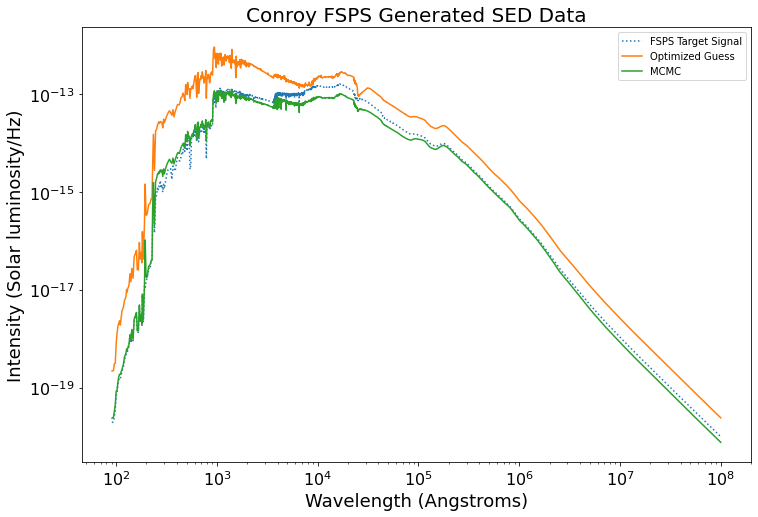

In [117]:
with Pool() as pool:
    
    text_label=[]

    for i in range(30):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(30)
    ub   = np.full(30, 1e9)

    length_of_lb = len(lb)
    
    
    no_of_steps=1000
    
    if(initial):
        print("Start Burntime Calculations ***********")
        perturbation = popt3 * 0.01
        guesses = [popt3 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
        burntime = np.round(1000)
        pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
        sampler.reset()
        clear_output(wait=True)
    
        print("Done Burning Steps! Now starting the Final Calculations:")
        print("*****************")
        
    else:
        
        # Reading in Final Position when sampler last ran
        pos = []
        with open(path + '/current_pos.csv') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                pos.append(list(map(float, row)))

        pos = np.array(pos)
        
        # Reading in saved variables from when sampler last ran
        test_weight_array3, snorm3, enorm3, spec_opt_guess3 = read_variables(path + "/save_variables.csv")
        
        
    print("Starting emcee ***********")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, args=(lb, ub, galactic_model_guess, wave, snorm3, enorm3), backend = backend)
    
    break_steps = 50000
    convergence_accuracy = 1.2
    convergence_check = True
    convergence_filename = path + '/convergence_file.csv'
    sampler_3D, likelihood, convergences = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm3, enorm3, wave, galactic_model_guess, path)
        
    title = "Conroy FSPS Generated SED Data"
    galaxy = "FSPS Target Signal"

    best_fit_log, exp_weight_array_log = print_and_plot_results(sampler, wave, snorm3, title, galaxy, galactic_model_guess)
     
    print("Input values are (weight array): \n {}".format(test_weight_array3))

    plt.loglog(wave, spec_opt_guess3, label = "Optimized Guess")
    plt.loglog(wave, best_fit_log, label = "MCMC")
    plt.legend()
    plt.savefig("galactic_plot_log_100000.jpg")
    plt.show()

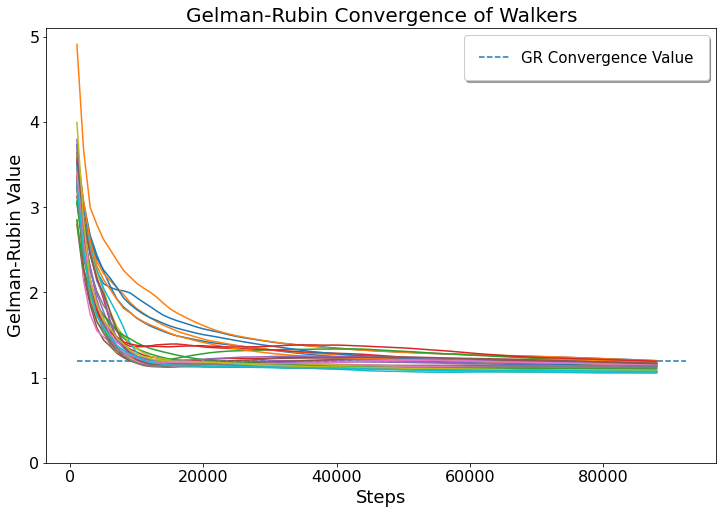

In [118]:
file_name = path + '/convergence_file.csv'

plot_convergences(file_name, convergence_accuracy, no_of_steps)

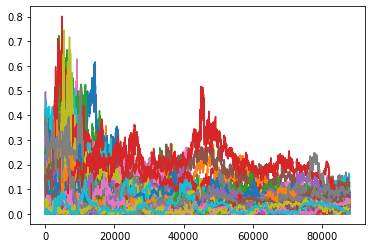

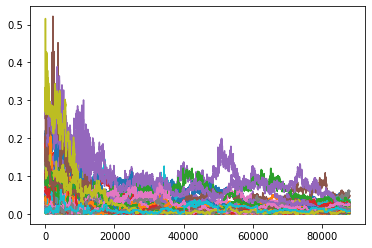

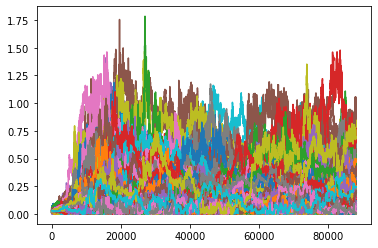

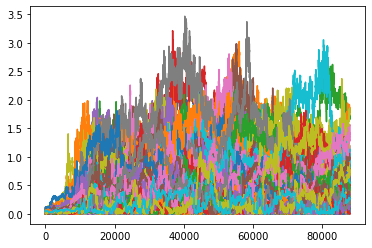

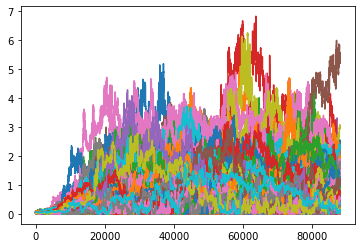

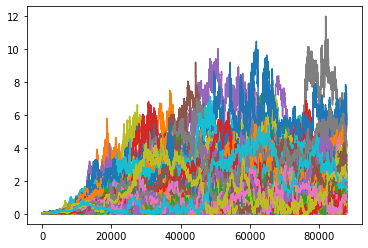

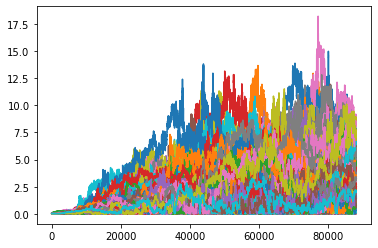

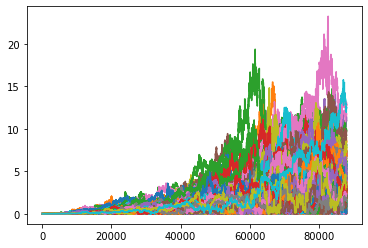

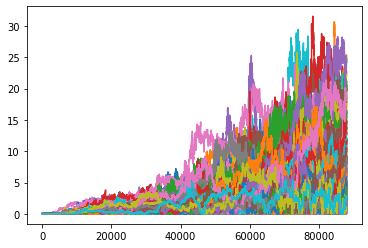

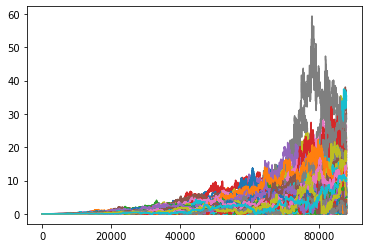

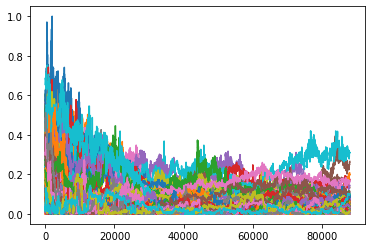

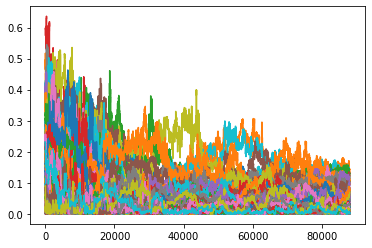

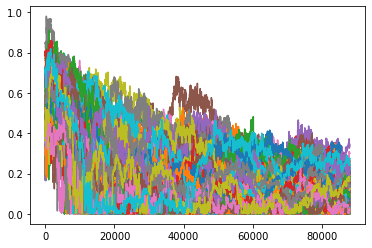

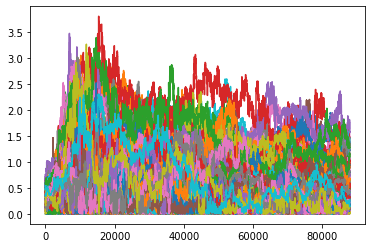

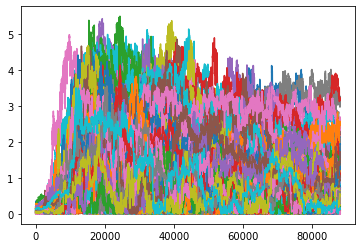

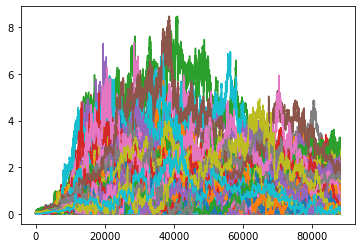

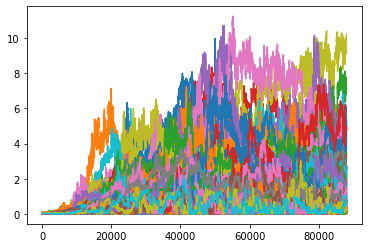

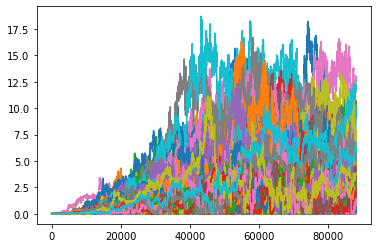

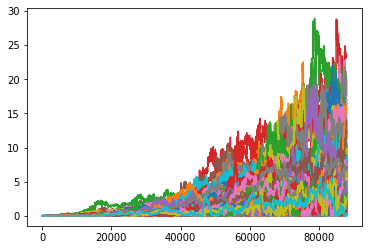

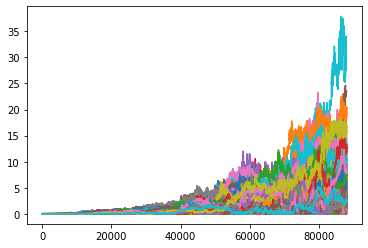

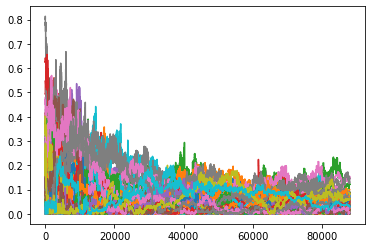

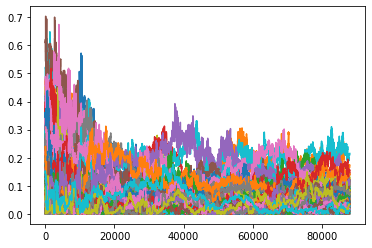

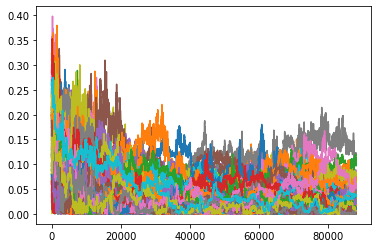

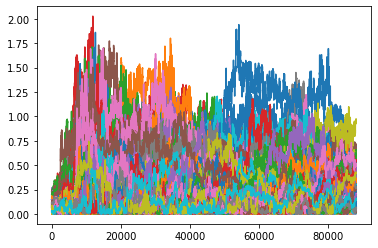

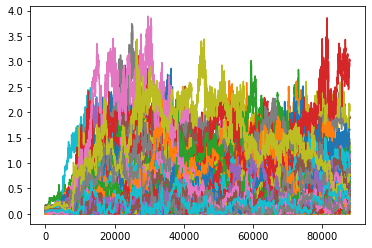

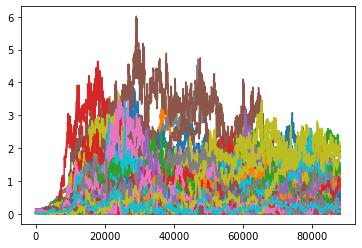

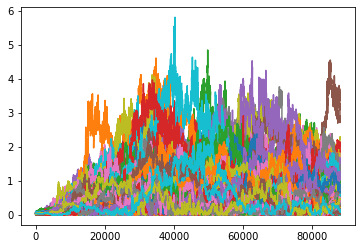

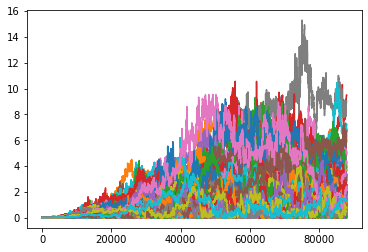

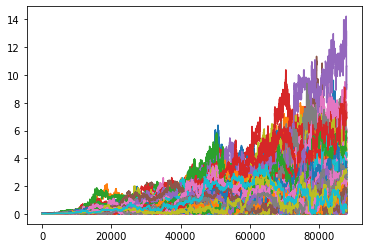

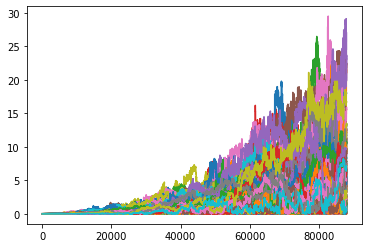

In [119]:
samples = sampler_3D.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler_3D.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

In [120]:
derived_weight = exp_weight_array_log.reshape((3, 10))
input_weight = test_weight_array3.reshape((3, 10))

derived_age_dist = np.zeros(10)
input_age_dist = np.zeros(10)
derived_met_dist = np.zeros(3)
input_met_dist = np.zeros(3)
met_err = np.zeros(3)
age_err = np.zeros(10)

y_unc = np.array(get_uncertainty(sampler))
y_unc = np.reshape(y_unc, (3,10))

for i in range(len(derived_weight)):
    for j in range(len(derived_weight[0])):
        derived_met_dist[i] += derived_weight[i][j]
        input_met_dist[i] += input_weight[i][j]
        met_err[i] += ((y_unc[i][j]) ** 2)
        
met_err = np.sqrt(met_err)

for i in range(len(derived_weight[0])):
    for j in range(len(derived_weight)):
        derived_age_dist[i] += derived_weight[j][i]
        input_age_dist[i] += input_weight[j][i]
        age_err[i] += (y_unc[j][i]) ** 2
    
age_err = np.sqrt(age_err)

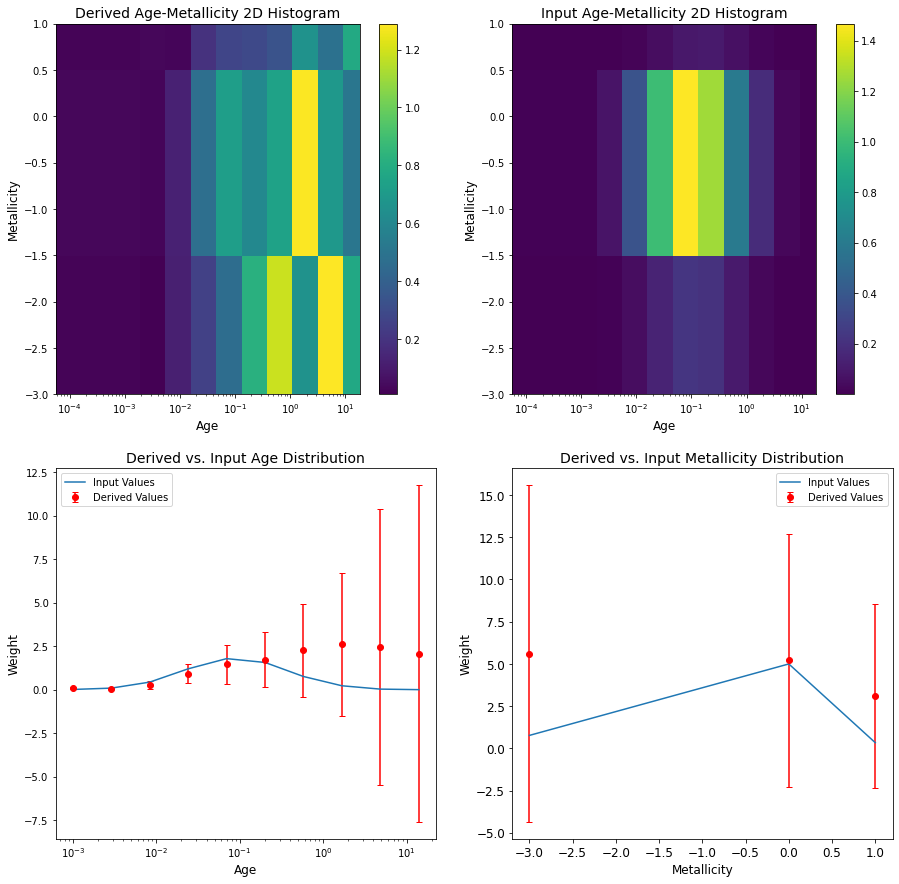

In [121]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plt.tick_params(axis='both', which='major', labelsize=12)

plt1 = axs[0, 0].pcolormesh(age_space, metallicity_space, derived_weight, shading='auto')
axs[0, 0].set_title('Derived Age-Metallicity 2D Histogram', fontsize = 14)
plt2 = axs[0, 1].pcolormesh(age_space, metallicity_space, input_weight, shading='auto')
axs[0, 1].set_title('Input Age-Metallicity 2D Histogram', fontsize = 14)
axs[1, 0].errorbar(age_space, derived_age_dist, yerr = age_err, fmt = 'ro', ecolor = 'red', capsize = 3, ms = 6, label = "Derived Values")
axs[1, 0].plot(age_space, input_age_dist, 'tab:blue', label = "Input Values")
axs[1, 0].set_title('Derived vs. Input Age Distribution', fontsize = 14)
axs[1, 1].errorbar(metallicity_space, derived_met_dist, yerr = met_err, fmt = 'ro', ecolor = 'red', capsize = 3, ms = 6, label = "Derived Values")
axs[1, 1].plot(metallicity_space, input_met_dist, 'tab:blue', label = "Input Values")
axs[1, 1].set_title('Derived vs. Input Metallicity Distribution', fontsize = 14)

fig.colorbar(plt1, ax=axs[0, 0])
fig.colorbar(plt2, ax=axs[0, 1])

iterator = 0
for ax in axs.flat:
    if iterator == 0:
        ax.set_xlabel('Age', fontsize = 12)
        ax.set_ylabel('Metallicity', fontsize = 12)
        ax.set_xscale('log')
        ax.set_ylim([-3, 1])
    if iterator == 1:
        ax.set_xlabel('Age', fontsize = 12)
        ax.set_ylabel('Metallicity', fontsize = 12)
        ax.set_xscale('log')
        ax.set_ylim([-3, 1])
    if iterator == 2:
        ax.set_xlabel('Age', fontsize = 12)
        ax.set_ylabel('Weight', fontsize = 12)
        ax.set_xscale('log')
        ax.legend()
    if iterator == 3:
        ax.set_xlabel('Metallicity', fontsize = 12)
        ax.set_ylabel('Weight', fontsize = 12) 
        ax.legend()
    iterator += 1
    
plt.savefig("gauss_distributions_2.jpg")    
plt.show()

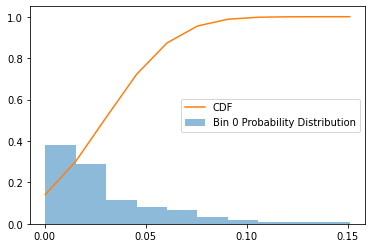

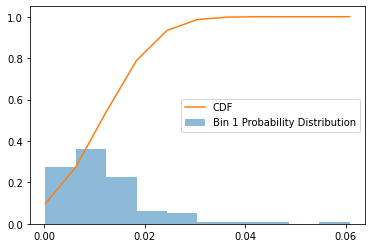

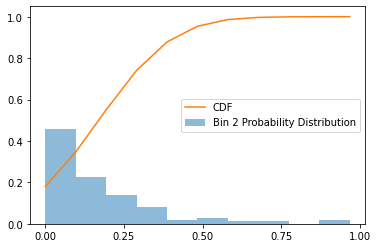

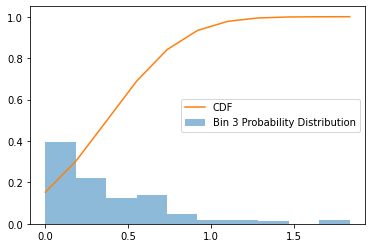

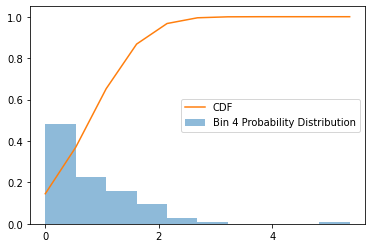

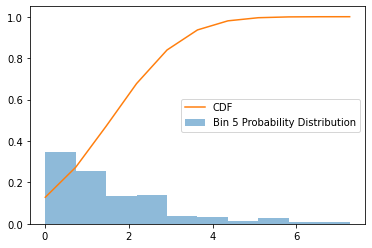

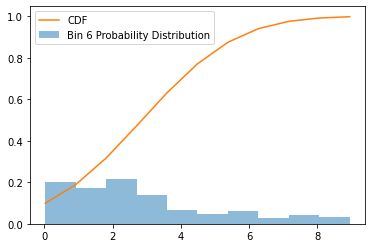

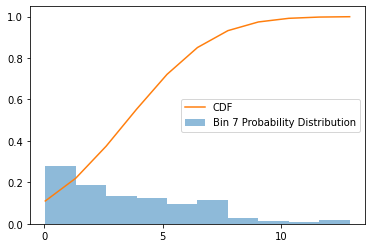

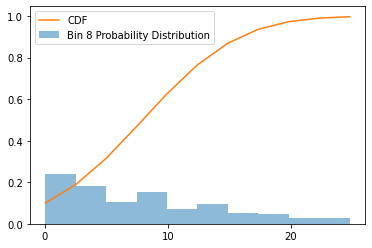

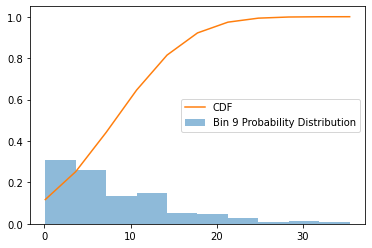

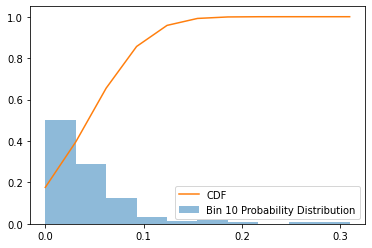

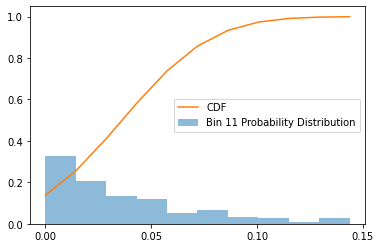

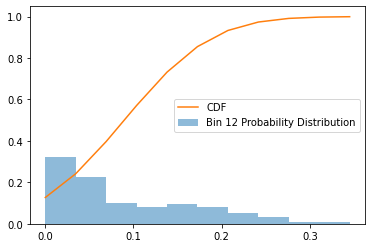

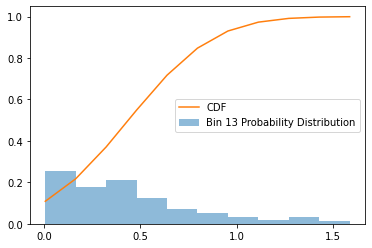

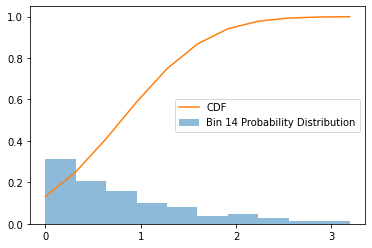

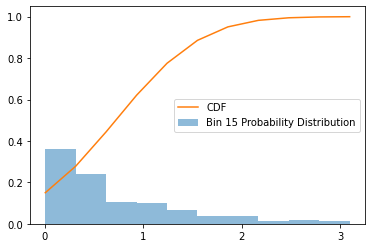

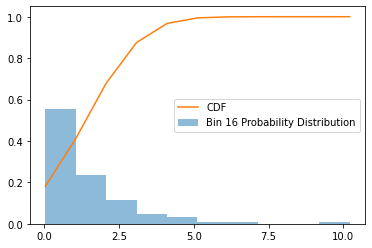

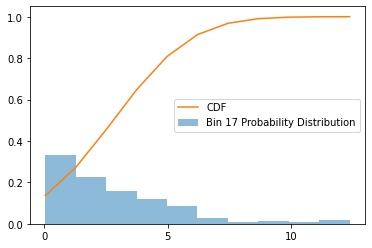

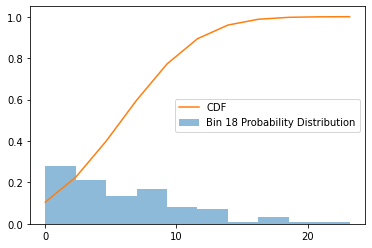

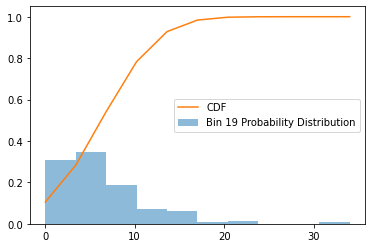

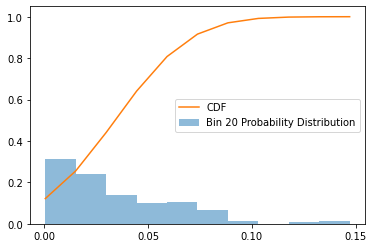

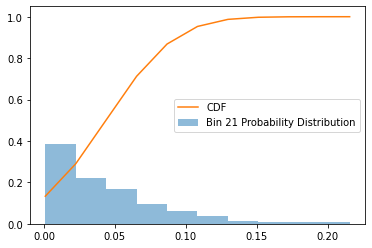

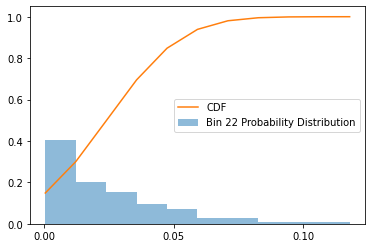

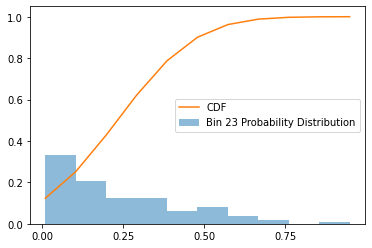

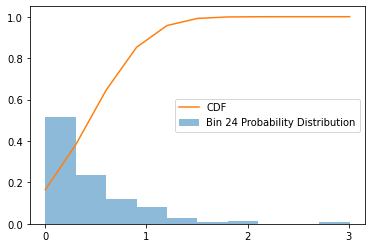

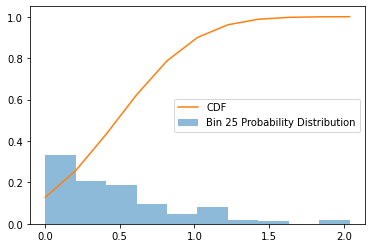

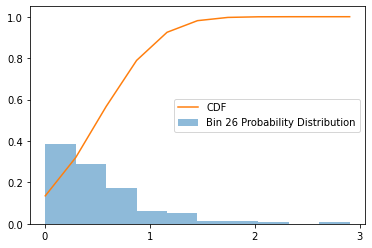

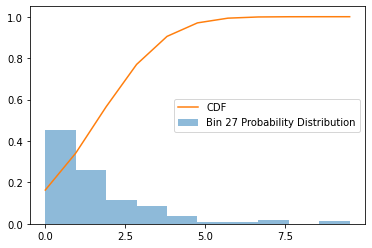

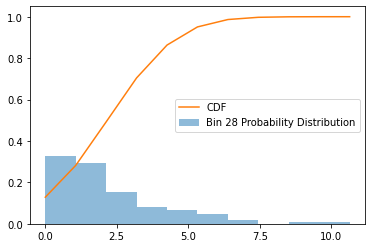

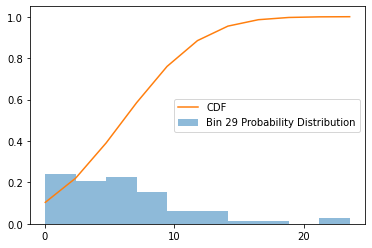

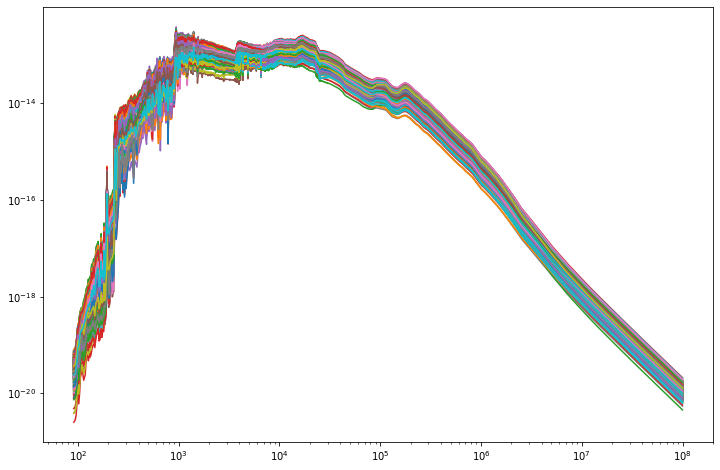

Derived Mass-to-light Ratio: 7.839e-02 +/- 2.221e-02
Input Mass-to-light Ratio: 1.294e-02
Standard Deviations Away: 2.947


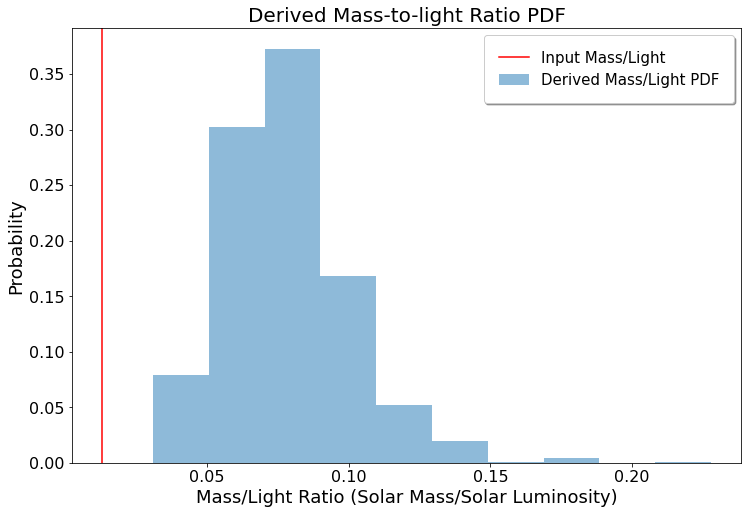

In [122]:
samples = 1000
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler_3D, samples, snorm3, wave)
input_mass_light = mass_to_light_calc(test_weight_array3, snorm3, wave)

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_log_pdf_3D.jpg")    
plt.show()

## Removing Metallicity Dependence

In [15]:
metallicity_space = np.array([0])
age_space = np.logspace(-3, 1.146, 10)

[0.00042557 0.00441534 0.02463013 0.07718861 0.13825857 0.15597312
 0.08830675 0.03457794 0.00702198 0.00117033]


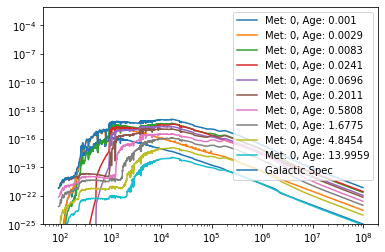

In [16]:
lb = 0
ub = int(5)

test_weight_array4 = np.array(generate_random_weight_array(lb, ub, metallicity_space, age_space))
plt.clf()
test_weight_array4 = test_weight_array4.flatten()
print(test_weight_array4)

row_array, column_array = convert_weight_array(test_weight_array4, metallicity_space, age_space)
met_array4, age_array4 = convert_arrays(row_array, column_array, metallicity_space, age_space)

total_spec4 = np.zeros(5994)

for i in range(len(met_array4)):
    met4 = np.array([met_array4[i]])
    age4 = np.array([age_array4[i]])
    
    theta4 = np.concatenate((met4, age4))
    spec4 = interpolating_spec(theta4)[0]
    spec4 *= test_weight_array4[i]
    plt.loglog(wave, spec4, label = "Met: {}, Age: {}".format(met4[0], age4[0]))
    total_spec4 += spec4

snorm4 = total_spec4 + np.random.normal(0., 1e-24, len(wave))
enorm4  = 1e-24 * np.ones((len(wave),))

plt.loglog(wave, snorm4, label = "Galactic Spec")
plt.legend()
plt.ylim([1e-25, 1e-2])
plt.show()

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Input values were (metallicity,age):
[0.00042557 0.00441534 0.02463013 0.07718861 0.13825857 0.15597312
 0.08830675 0.03457794 0.00702198 0.00117033]
Optimizing Guess ***********


/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[6.61611951e-06 8.66986283e-03 1.17069862e-01 3.30811426e-02
 2.03284864e-02 2.19498818e-02 1.54339321e-02 1.34197893e-02
 1.11217446e-02 1.04734324e-02]


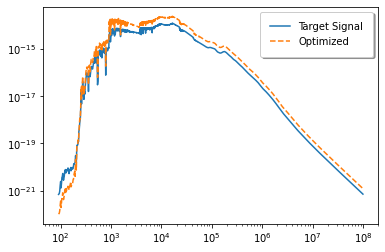

In [17]:
text_label = []

for i in range(10):
    text_label.append('mass'+ str(i))
    
lb   = np.zeros(10)
ub   = np.full(10, 1e10)

starting_weight_array = np.full(10, 0.01)

print("Current Starting Position")
print(starting_weight_array)
print("Input values were (metallicity,age):")
print(test_weight_array4)

print('Optimizing Guess ***********')

popt4 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, wave, snorm4, enorm4)
print(popt4)

spec_opt_guess4 = galactic_model_guess(popt4, wave)

plt.loglog(wave, snorm4, label='Target Signal')
plt.loglog(wave,spec_opt_guess4, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
plt.show()

Steps Taken:  10000 Likelihood:  -996.3236028551202


<ipython-input-2-9790491ea630>:236: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [0.00182421 0.00521816 0.01217316 0.05298859 0.17481912 0.09129131
 0.13043069 0.15572453 0.43689569 0.96827583]
Input values are (weight array): 
 [0.00042557 0.00441534 0.02463013 0.07718861 0.13825857 0.15597312
 0.08830675 0.03457794 0.00702198 0.00117033]


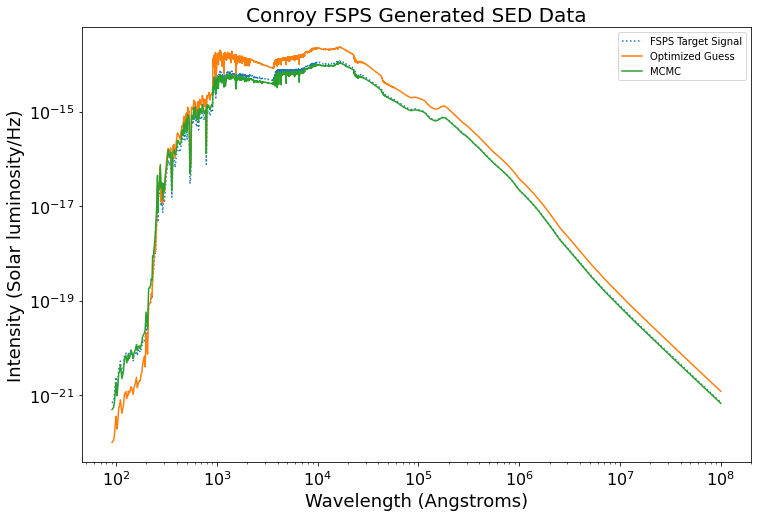

In [25]:
with Pool() as pool:
    perturbation = popt4 * 0.01
    no_of_Chain=500
    no_of_steps=5000

    text_label=[]

    for i in range(10):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(10)
    ub   = np.full(10, 1e9)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt4 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 2), args=(lb, ub, galactic_model_guess, wave, snorm4, enorm4))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 10000
    convergence_accuracy = 1e-5
    convergence_check = False
    
    sampler_1D, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm4, enorm4, wave, galactic_model_guess)
    
    title = "Conroy FSPS Generated SED Data"
    galaxy = "FSPS Target Signal"

    best_fit4, exp_weight_array4 = print_and_plot_results(sampler_1D, wave, snorm4, title, galaxy, galactic_model_guess)

    print("Input values are (weight array): \n {}".format(test_weight_array4))
    
    plt.loglog(wave, spec_opt_guess4, label = "Optimized Guess")
    plt.loglog(wave, best_fit4, label = "MCMC")
    plt.legend()
    plt.show()

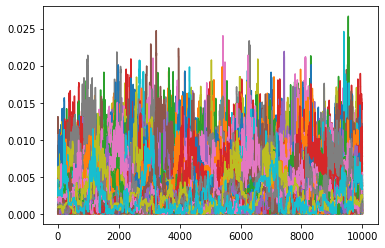

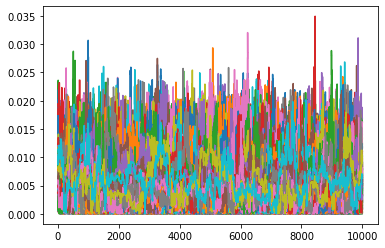

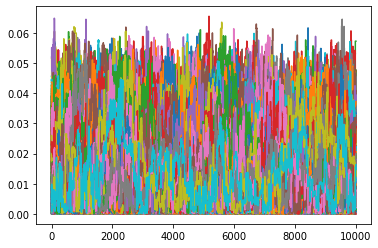

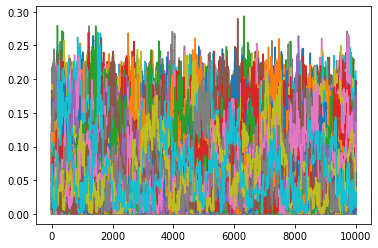

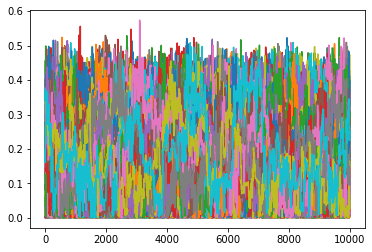

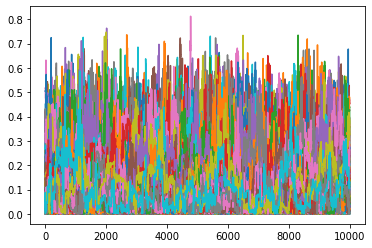

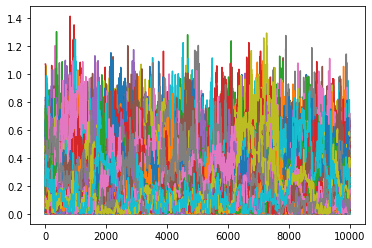

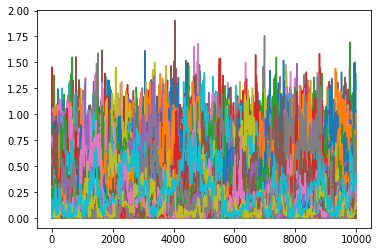

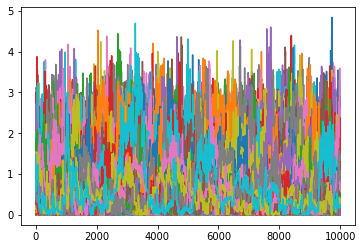

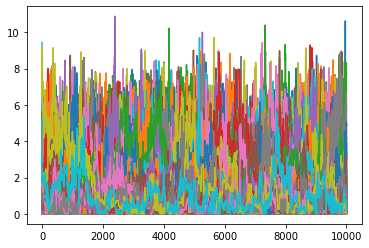

In [26]:
samples = sampler_1D.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler_1D.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

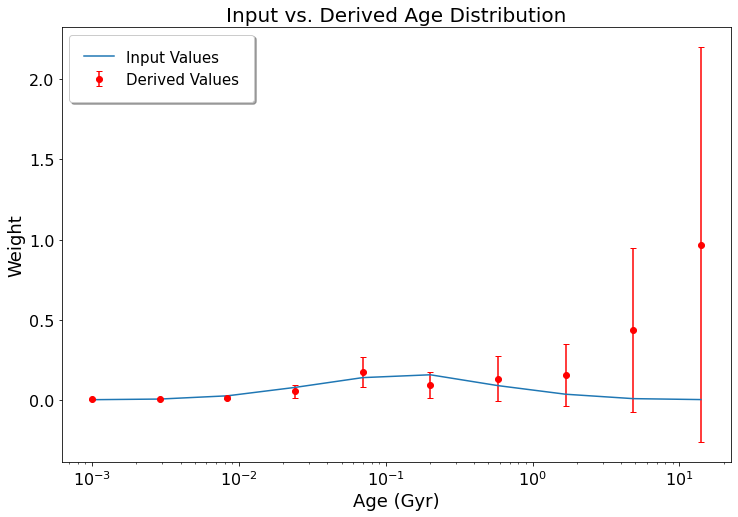

In [27]:
fig= plt.figure(figsize=(12,8))
y_unc = np.array(get_uncertainty(sampler_1D))
plt.errorbar(age_space, exp_weight_array4, yerr = y_unc, fmt = 'ro', ecolor = 'red', capsize = 3, ms = 6, label = "Derived Values")
#plt.errorbar(age_space, exp_weight_array4, yerr = y_unc_norm, fmt = 'bo', ecolor = 'blue', capsize = 3, ms = 6, label = "Normalized Derived Values")
plt.plot(age_space, test_weight_array4, 'tab:blue', label = "Input Values")
plt.xscale("log")
plt.title('Input vs. Derived Age Distribution', fontsize = 20)
plt.ylabel('Weight', fontsize = 18) # Labeling the x-axis
plt.xlabel('Age (Gyr)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  
plt.savefig("gauss_distributions_1D_2.jpg")    
plt.show()

## Testing on Observable Data

In [9]:
ngc_337_rest_wave, ngc_337_flux, ngc_337_obs_wave, ngc_337_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_337.dat")
ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_obs_wave, ngc_4486_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4486.dat")
ngc_4594_rest_wave, ngc_4594_flux, ngc_4594_obs_wave, ngc_4594_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4594.dat")
ngc_4826_rest_wave, ngc_4826_flux, ngc_4826_obs_wave, ngc_4826_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4826.dat")
ngc_4486_flux_err  = 1e-24 * np.ones(len(ngc_4486_flux))

In [10]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.logspace(-3, 1.146, 10)

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Optimizing Guess ***********


/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.23683031 0.26240638 0.00548278 0.06841913 0.04084744 0.03048704
 0.02898212 0.0235725  0.01442296 0.01150347 0.30016766 0.38877875
 0.49334946 0.04178852 0.08670539 0.08539866 0.0497331  0.02609188
 0.01291972 0.01007329 0.35929796 0.45574046 0.45767462 0.03195708
 0.09962617 0.11628006 0.09477313 0.03751385 0.02062383 0.01005104]


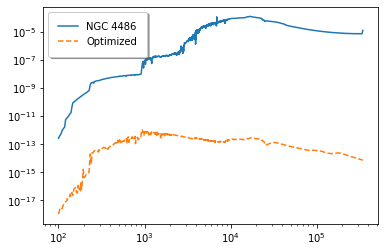

In [11]:
lb   = np.zeros(30)
ub   = np.full(30, 1e15)

starting_weight_array = np.zeros(30) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt)

ngc_4486_opt_guess= galactic_model_guess(popt, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

Steps Taken:  15000 Likelihood:  -458.12684477456503


<ipython-input-2-9790491ea630>:236: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [6.49077661e+04 8.61099700e+04 9.16891133e+05 5.08710100e+07
 1.25927792e+07 1.06410561e+06 1.09853989e+07 3.73729283e+06
 4.66023210e+06 3.08500873e+06 1.63327755e+05 1.60749946e+05
 1.86161341e+08 5.14877237e+06 7.07514637e+06 6.76060048e+07
 1.32056359e+07 4.44249628e+06 2.89148673e+05 3.26577336e+05
 1.54051028e+05 2.89853827e+05 1.08765787e+08 2.42508510e+06
 7.42238147e+07 5.25940019e+06 1.80554231e+06 2.50081557e+07
 3.53508800e+06 7.73099076e+05]


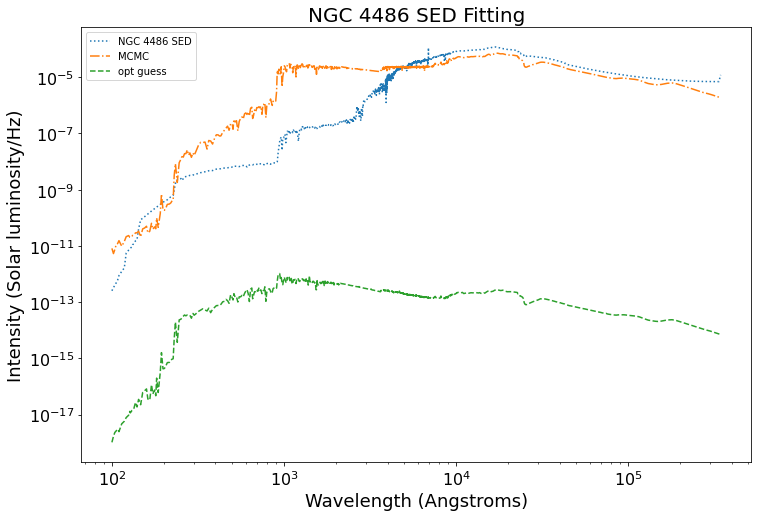

In [12]:
with Pool() as pool:
    perturbation = popt * 0.10
    no_of_Chain=500
    no_of_steps=5000

    text_label=[]

    for i in range(30):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(30)
    ub   = np.full(30, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(5000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 10), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 15000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler1, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit1, exp_weight_array1 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit1, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess,label='opt guess', ls='--')
    plt.legend()
    plt.savefig("ngc_4486_log.jpg")
    plt.show()

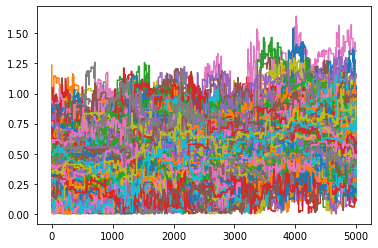

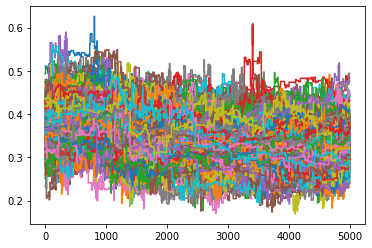

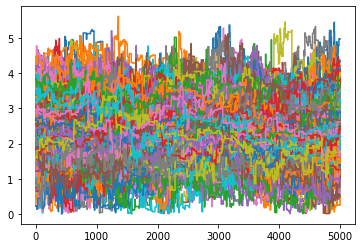

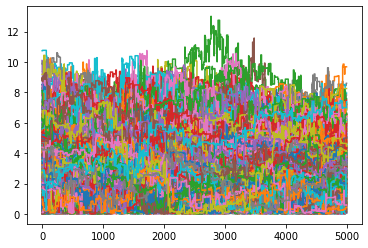

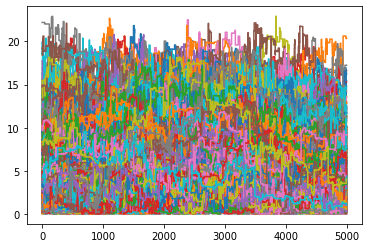

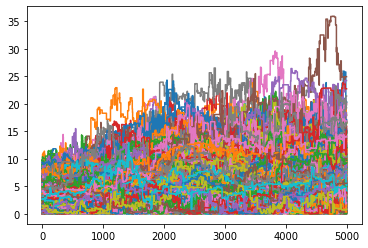

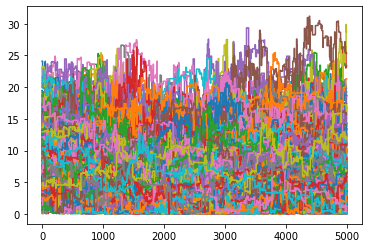

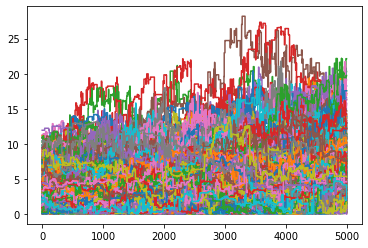

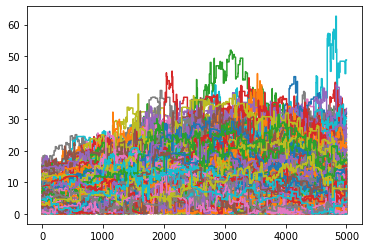

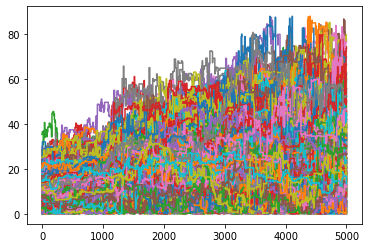

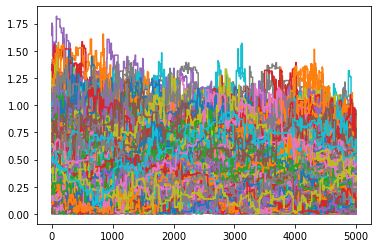

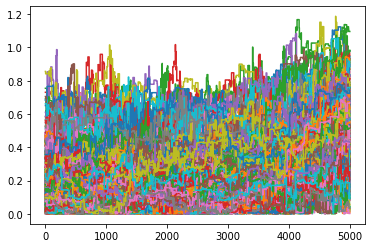

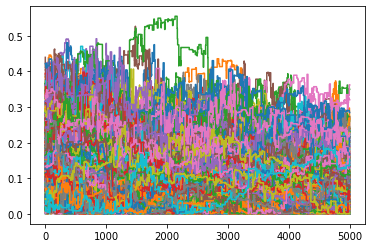

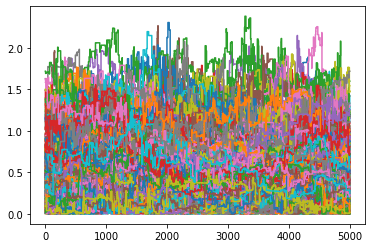

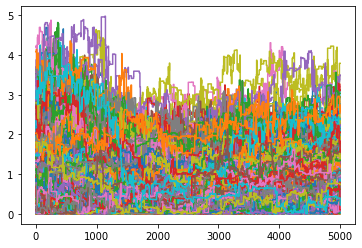

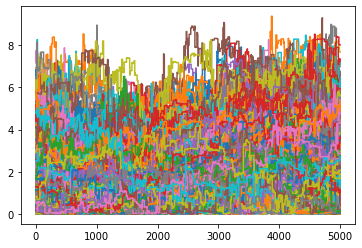

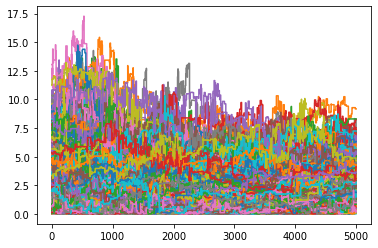

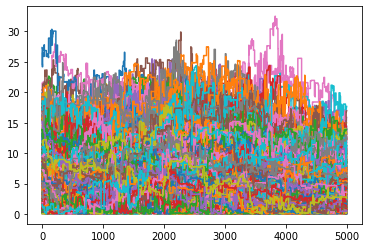

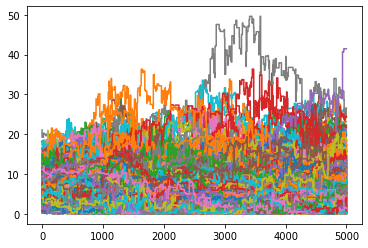

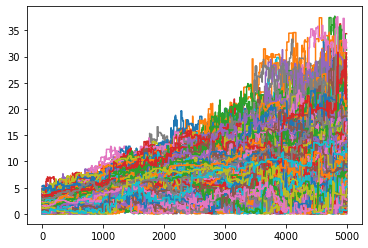

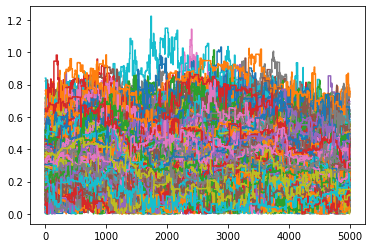

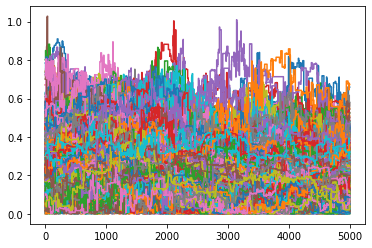

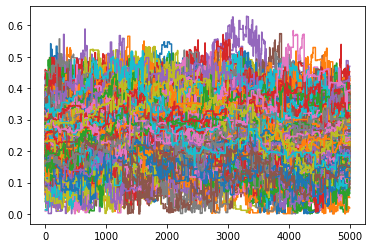

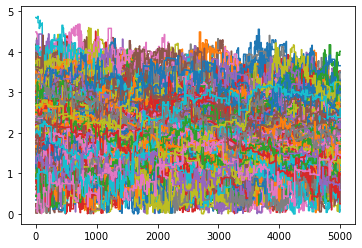

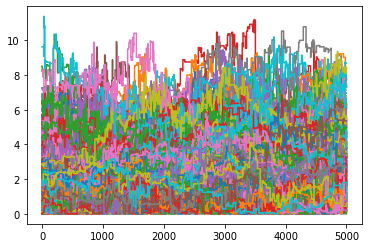

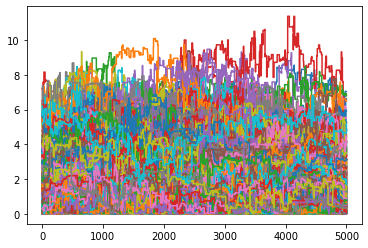

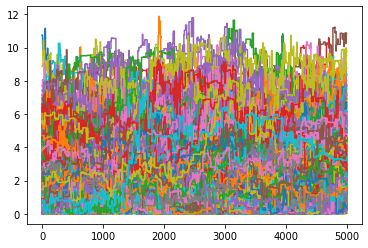

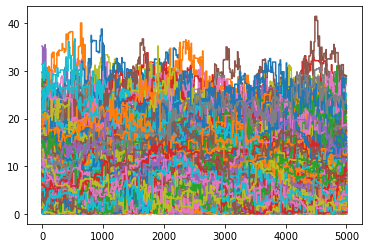

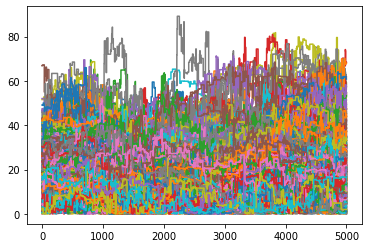

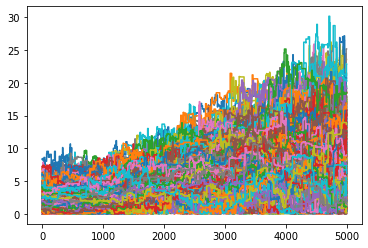

In [33]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()